# COVID-19 (Normal vs Log-scale chart)
data source: https://github.com/CSSEGISandData/COVID-19
* https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

Objectives:
1. อ่านข้อมูลที่อยู่ในรูป wide format แล้วแปลงเป็น long format
1. การสร้าง interactive chart
1. แสดงกราฟแบบ log-scale
1. เปรียบเทียบกาาแสดงการที่มีแกนแสดงค่าแบบปกติเทียบกับแกนที่แสดงเป็น log scale

---
* author:  [Prasert Kanawattanachai](prasert.k@chula.ac.th)
* YouTube: https://www.youtube.com/prasertcbs
* [Chulalongkorn Business School](https://www.cbs.chula.ac.th/en/)
---

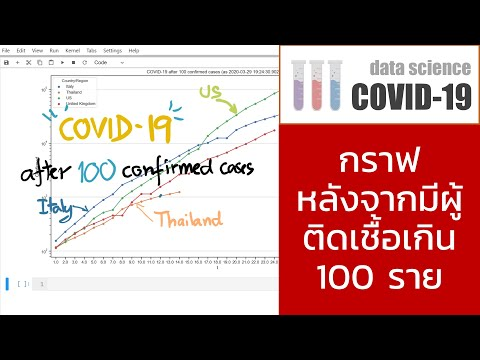

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('K3YKX3oQ2Wg', width=720, height=405)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
pd.set_option('display.max_rows', 10)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print(f'pandas   version: {pd.__version__}')
print(f'seaborn  version: {sns.__version__}')

pandas   version: 1.0.3
seaborn  version: 0.10.0


In [5]:
pd.Timestamp.now()

Timestamp('2020-03-30 13:43:24.225424')

## read data from github

In [6]:
def read_covid_time_series():
    '''
    read Johns Hopkins COVID-19 time series data
    data source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
    '''
    path='https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_'
    status=['Confirmed', 'Deaths', 'Recovered']
    dfs=[pd.read_csv(f'{path}{s.lower()}_global.csv') for s in status]
    
    df=pd.concat(dfs, keys=status)
    
    dtmps=[pd.melt(df.loc[k], 
                id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                var_name='Date', value_name=k) for k in status]
    dx=[d.set_index(['Province/State', 'Country/Region', 'Date']) for d in dtmps]
    dcovid=pd.concat(dx, axis=1)
    dcovid.reset_index(inplace=True)
    dcovid=dcovid.loc[:, ~dcovid.columns.duplicated()]
    dcovid['Date']=pd.to_datetime(dcovid['Date'])
    dcovid=dcovid.sort_values(['Country/Region', 'Province/State', 'Date']).reset_index(drop=True)
    dcountry=dcovid.groupby(['Country/Region', 'Date']).sum()[['Confirmed', 'Deaths', 'Recovered']]
    dcountry.reset_index(inplace=True)
    dcountry['daily_new_patient']=dcountry.groupby(['Country/Region'])['Confirmed'].diff()
    dcountry['daily_new_patient_pct']=dcountry.groupby(['Country/Region'])['Confirmed'].pct_change()
    return dcountry

In [7]:
dcountry=read_covid_time_series()
# dcountry[dcountry['Country/Region']=='Thailand']
dcountry[dcountry['Country/Region'].isin(['Thailand', 'Malaysia'])]


,Country/Region,Date,Confirmed,Deaths,Recovered,daily_new_patient,daily_new_patient_pct
6936,Malaysia,2020-01-22,0.0,0.0,0,NaN,NaN
6937,Malaysia,2020-01-23,0.0,0.0,0,0.0,NaN
6938,Malaysia,2020-01-24,0.0,0.0,0,0.0,NaN
6939,Malaysia,2020-01-25,3.0,0.0,0,3.0,inf
6940,Malaysia,2020-01-26,4.0,0.0,0,1.0,0.333333
...,...,...,...,...,...,...,...
10875,Thailand,2020-03-25,934.0,4.0,70,107.0,0.129383
10876,Thailand,2020-03-26,1045.0,4.0,88,111.0,0.118844
10877,Thailand,2020-03-27,1136.0,5.0,97,91.0,0.087081
10878,Thailand,2020-03-28,1245.0,6.0,97,109.0,0.095951


## Interactive chart

### normal scale

In [8]:
dq=dcountry[['Country/Region', 'Confirmed']].groupby('Country/Region').max() > 100
country_list=dq.index[dq.Confirmed]
# country_list

@interact(country=country_list, country2=country_list)
def plot_chart(country, country2):
    df=dcountry[dcountry['Country/Region'].isin([country, country2])]
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='Date', y='Confirmed', hue='Country/Region')
    plt.grid()

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

### normal vs log

In [9]:
# country_list=pd.Series(dcountry['Country/Region'].unique()).sort_values() # all countries

dq=dcountry[['Country/Region', 'Confirmed']].groupby('Country/Region').max() > 100
country_list=dq.index[dq.Confirmed]
# country_list
@interact(country=country_list)
def plot_chart(country):
    df=dcountry[dcountry['Country/Region'].isin([country])]
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=df, x='Date', y='Confirmed', ax=ax, color='lightblue', label='normal')
    ax2=ax.twinx()
    ax2.set_yscale('log', basey=10)
    sns.lineplot(x=df.Date, y=df['Confirmed'], ax=ax2, color='salmon', label='log')
    ax2.grid()
    plt.title(f'COVID-19 in {country}')
    fig.legend()

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

### log vs log

In [10]:
dq=dcountry[['Country/Region', 'Confirmed']].groupby('Country/Region').max() > 100
country_list=dq.index[dq.Confirmed]
# country_list
@interact(country=country_list, country2=country_list)
def plot_chart(country, country2):
    df=dcountry[dcountry['Country/Region'].isin([country, country2])]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_yscale('log', basey=10)
    ax.grid()
    sns.lineplot(data=df, x='Date', y='Confirmed', hue='Country/Region', ax=ax)

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

### daily new confirmed cases

In [11]:
dq=dcountry[['Country/Region', 'Confirmed']].groupby('Country/Region').max() > 100
country_list=dq.index[dq.Confirmed]
# country_list

@interact(country=country_list, country2=country_list)
def plot_chart(country, country2):
    df=dcountry[dcountry['Country/Region'].isin([country, country2])]
    fig, ax = plt.subplots(figsize=(10, 7))
#     ax.set_yscale('log', basey=10)
    ax.grid()
    sns.lineplot(data=df, x='Date', y='daily_new_patient', hue='Country/Region', ax=ax)

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

## เมื่อในประเทศมีผู้ติดเชื้อเกิน 100 ราย

In [12]:
dcountry[dcountry.Confirmed >= 100]

,Country/Region,Date,Confirmed,Deaths,Recovered,daily_new_patient,daily_new_patient_pct
65,Afghanistan,2020-03-27,110.0,4.0,2,16.0,0.170213
66,Afghanistan,2020-03-28,110.0,4.0,2,0.0,0.000000
67,Afghanistan,2020-03-29,120.0,4.0,2,10.0,0.090909
129,Albania,2020-03-23,104.0,4.0,2,15.0,0.168539
130,Albania,2020-03-24,123.0,5.0,10,19.0,0.182692
...,...,...,...,...,...,...,...
11828,Vietnam,2020-03-26,153.0,0.0,20,12.0,0.085106
11829,Vietnam,2020-03-27,163.0,0.0,20,10.0,0.065359
11830,Vietnam,2020-03-28,174.0,0.0,21,11.0,0.067485
11831,Vietnam,2020-03-29,188.0,0.0,25,14.0,0.080460


In [13]:
def confirmed_cases_gt(n=100):
    '''
    ดึงแถวที่มีค่า Confirmed มากกว่าเท่ากับค่า n ที่กำหนด เช่น 100 ราย
    '''
    dcountry=read_covid_time_series()
    df=dcountry[dcountry.Confirmed >= n].reset_index(drop=True)
    df['t'] = df.groupby('Country/Region')['Confirmed'].rank(ascending=True, method='first')
    return df

In [15]:
dt=confirmed_cases_gt(100)
dt

,Country/Region,Date,Confirmed,Deaths,Recovered,daily_new_patient,daily_new_patient_pct,t
0,Afghanistan,2020-03-27,110,4,0.0,16.0,0.170213,1.0
1,Afghanistan,2020-03-28,110,4,0.0,0.0,0.000000,2.0
2,Albania,2020-03-23,104,4,49.0,15.0,0.168539,1.0
3,Albania,2020-03-24,123,5,0.0,19.0,0.182692,2.0
4,Albania,2020-03-25,146,5,3.0,23.0,0.186992,3.0
...,...,...,...,...,...,...,...,...
1385,Vietnam,2020-03-24,134,0,1.0,11.0,0.089431,3.0
1386,Vietnam,2020-03-25,141,0,0.0,7.0,0.052239,4.0
1387,Vietnam,2020-03-26,153,0,0.0,12.0,0.085106,5.0
1388,Vietnam,2020-03-27,163,0,0.0,10.0,0.065359,6.0


In [16]:
dq=dt[['Country/Region', 'Confirmed']].groupby('Country/Region').max() >= 100
country_list=dq.index[dq.Confirmed]
country_list

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Belgium',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica',
       'Cote d'Ivoire', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia',
       'Finland', 'France', 'Germany', 'Ghana', 'Greece', 'Hungary', 'Iceland',
       'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Jordan', 'Kazakhstan', 'Korea, South', 'Kuwait', 'Latvia',
       'Lebanon', 'Lithuania', 'Luxembourg', 'Malaysia', 'Malta', 'Mauritius',
       'Mexico', 'Moldova', 'Morocco', 'Netherlands', 'New Zealand',
       'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia',
       'San Marino', 'Saudi Ar

### เปรียบเทียบ 2 ประเทศ

In [17]:
dq=dt[['Country/Region', 'Confirmed']].groupby('Country/Region').max() >= 100
country_list=dq.index[dq.Confirmed]
# country_list
@interact(country=country_list, country2=country_list, yscale=['log', 'normal'])
def plot_chart(country, country2, yscale):
    sns.set(style="ticks", rc={"lines.linewidth": 0.7})
    df=dt[dt['Country/Region'].isin([country, country2])]
    fig, ax = plt.subplots(figsize=(16, 6))
    if yscale=='log':
        ax.set_yscale('log', basey=10)
    ax.grid()
    sns.pointplot(data=df, x='t', y='Confirmed', hue='Country/Region', ax=ax)
#     sns.lineplot(data=df, x='t', y='Confirmed', hue='Couccntry/Region', ax=ax)
    plt.title(f'COVID-19 after 100 confirmed cases (as {pd.Timestamp.now()})')
    # save chart to file
    plt.savefig(f'100days_{country}_{country2}.svg')

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

### แสดงหลาย ๆ ประเทศพร้อม ๆ กัน

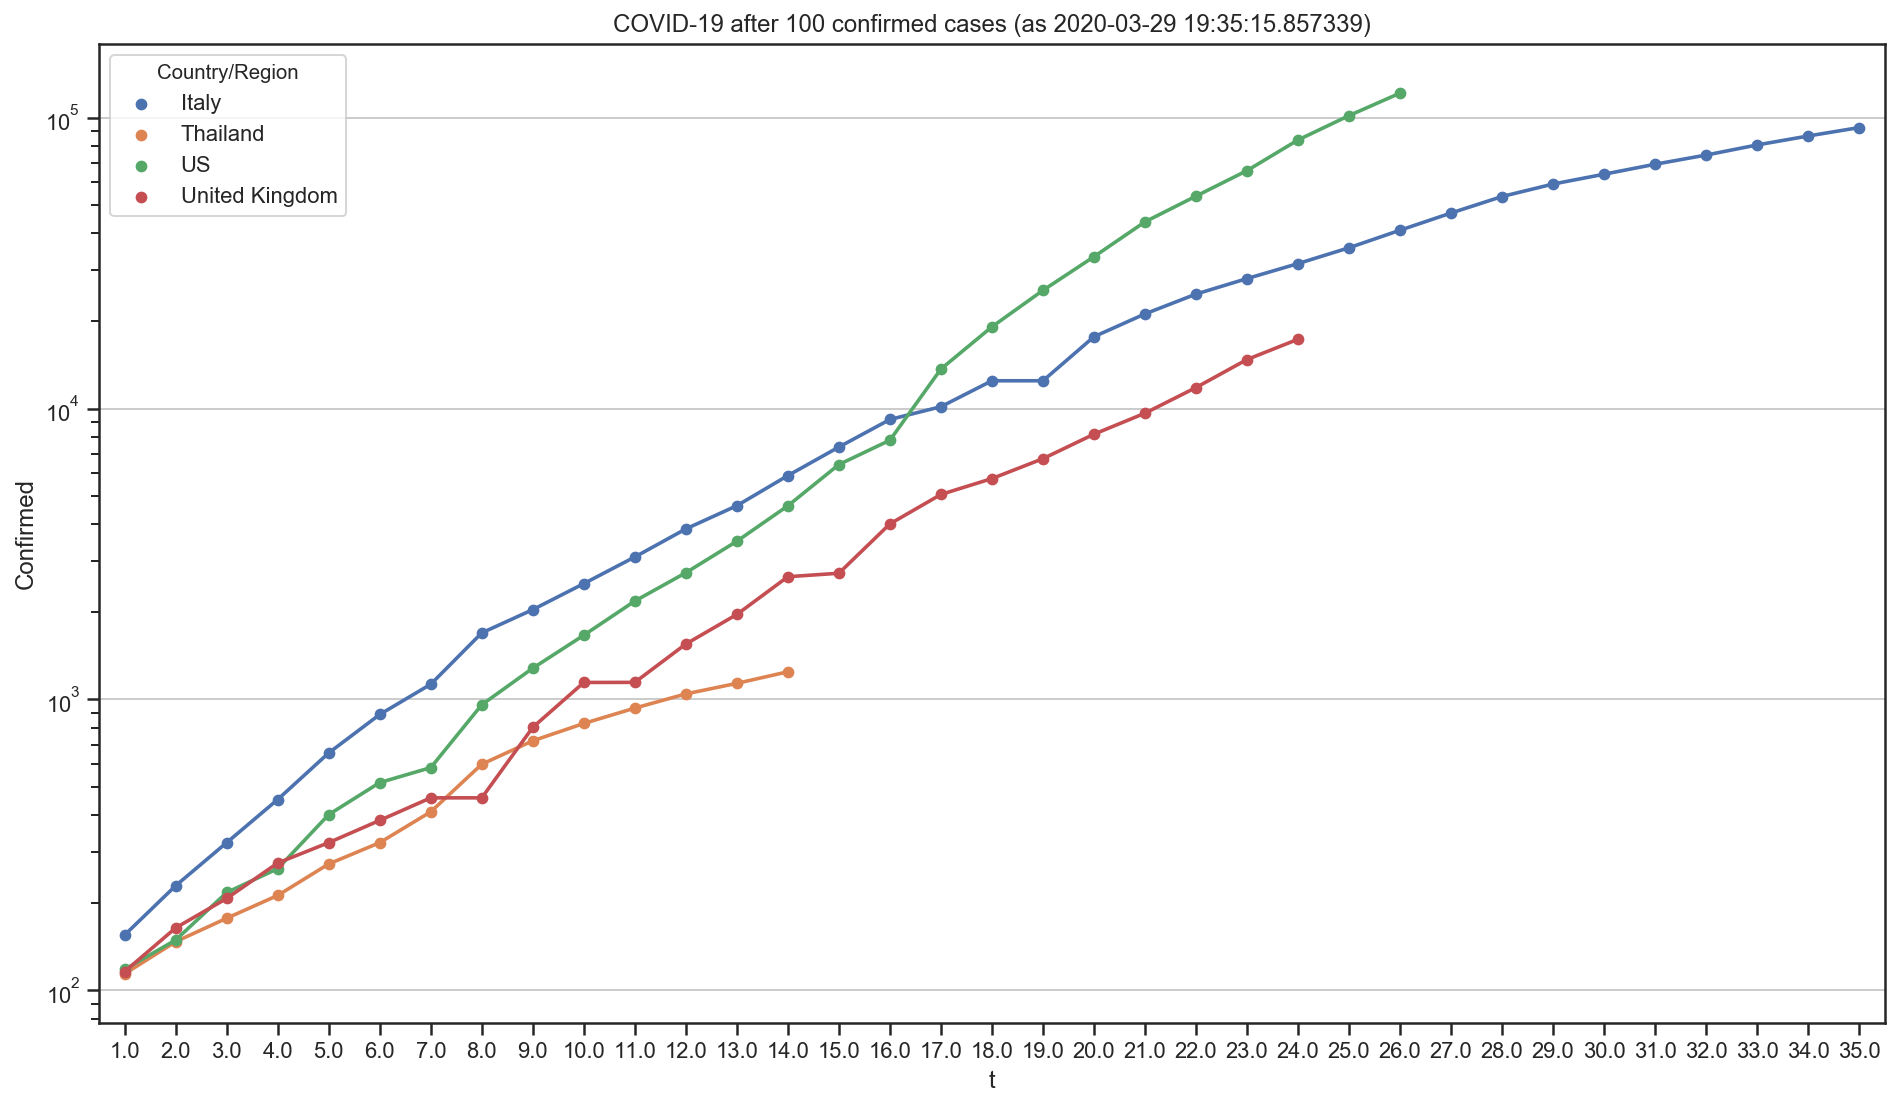

In [18]:
def plot_chart(countries, yscale='log'):
    sns.set(style="ticks", rc={"lines.linewidth": 1})
    df=dt[dt['Country/Region'].isin(countries)]
    fig, ax = plt.subplots(figsize=(16, 9))
    if yscale=='log':
        ax.set_yscale('log', basey=10)
    ax.grid()
    sns.pointplot(data=df, x='t', y='Confirmed', hue='Country/Region', ax=ax)
#     sns.lineplot(data=df, x='t', y='Confirmed', hue='Country/Region', ax=ax)
    plt.title(f'COVID-19 after 100 confirmed cases (as {pd.Timestamp.now()})')

countries=['Thailand', 'Italy', 'United Kingdom', 'US']
plot_chart(countries, 'log')

# save chart to file
# plt.savefig('100days.png')
plt.savefig('100days.svg')